# VWAP8 Strategy Debug Notebook (Orders + Fills + PnL)

This notebook analyzes three logs from one strategy run:

- **order.csv** → what the strategy intended to do (orders submitted, side/type/qty, etc.)
- **fill.csv** → what actually got executed (fills, liquidity taking/adding, execution cost, etc.)
- **pnl.csv** → the outcome over time (cumulative PnL and derived incremental PnL)

## Goal
Move from “PnL is bad” to “Why is PnL bad?” by linking:

**Orders → Fills → PnL**

We will answer:
1) Is the strategy structurally losing (continuous drawdown vs a few shocks)?
2) Is execution the main driver (spread crossing / fees / liquidity removal)?
3) When does it fail (time-of-day)?
4) Which events drive the worst losses (outlier minutes)?
5) Do fills map back to orders correctly (OrderID join coverage)?


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

PNL_PATH   = "BACK_VWAP8_2025-12-10_215515_start_09-13-2019_end_09-13-2019_pnl.csv"
FILL_PATH  = "BACK_VWAP8_2025-12-10_215515_start_09-13-2019_end_09-13-2019_fill.csv"
ORDER_PATH = "BACK_VWAP8_2025-12-10_215515_start_09-13-2019_end_09-13-2019_order.csv"


## 1) Load files + inspect schema

Why:
- Make sure we loaded the correct files
- Confirm column names
- Prevent small formatting issues from breaking later steps

What we do:
- Read CSVs
- Strip whitespace from column names
- Print columns + preview rows


In [4]:
pnl   = pd.read_csv(PNL_PATH)
fills = pd.read_csv(FILL_PATH)
orders= pd.read_csv(ORDER_PATH)

# Standardize column names (defensive)
pnl    = pnl.rename(columns={c: c.strip() for c in pnl.columns})
fills  = fills.rename(columns={c: c.strip() for c in fills.columns})
orders = orders.rename(columns={c: c.strip() for c in orders.columns})

print("pnl columns:", pnl.columns.tolist())
print("fills columns:", fills.columns.tolist())
print("orders columns:", orders.columns.tolist())

display(pnl.head(3))
display(fills.head(3))
display(orders.head(3))


pnl columns: ['Name', 'Time', 'Cumulative PnL']
fills columns: ['StrategyName', 'TradeTime', 'Symbol', 'Quantity', 'Price', 'ExecutionCost', 'LiquidityAction', 'LiquidityCode', 'RawLiquidity', 'Account', 'Trader', 'MarketCenter', 'OrderID', 'ExecID', 'TransactionType']
orders columns: ['StrategyName', 'EntryTime', 'LastModTime', 'State', 'LastUpdateType', 'Symbol', 'Side', 'Type', 'TIF', 'Price', 'Quantity', 'DisplayQuantity', 'FilledQty', 'Remains', 'AvgFillPrice', 'ExecutionCost', 'Account', 'Trader', 'Broker', 'MarketCenter', 'OrderId', 'Tag', 'Reason', 'Closure']


,Name,Time,Cumulative PnL
0,VWAP8,2019-Sep-13 13:30:15.382104,-369.463299
1,VWAP8,2019-Sep-13 13:31:19.387251,-1444.353438
2,VWAP8,2019-Sep-13 13:32:25.862841,-2357.862220


,StrategyName,TradeTime,Symbol,Quantity,Price,ExecutionCost,LiquidityAction,LiquidityCode,RawLiquidity,Account,Trader,MarketCenter,OrderID,ExecID,TransactionType
0,VWAP8,2019-Sep-13 13:30:01.012805,AAPL,-1,219.64,0.00612,REMOVED,0,NaN,SIM-1001-101,dlariviere,NASDAQ,369229748505854,NaN,FILL
1,VWAP8,2019-Sep-13 13:30:01.541646,MSFT,1,137.92,0.00120,REMOVED,0,NaN,SIM-1001-101,dlariviere,NASDAQ,369229748505855,NaN,FILL
2,VWAP8,2019-Sep-13 13:30:01.630178,MSFT,1,140.84,0.00120,REMOVED,0,NaN,SIM-1001-101,dlariviere,NASDAQ,369229748505856,NaN,FILL


,StrategyName,EntryTime,LastModTime,State,LastUpdateType,Symbol,Side,Type,TIF,Price,...,AvgFillPrice,ExecutionCost,Account,Trader,Broker,MarketCenter,OrderId,Tag,Reason,Closure
0,VWAP8,2019-Sep-13 13:30:01.012805,2019-Sep-13 13:30:01.012805,FILLED,FILL,AAPL,SELL,MARKET,DAY,219.64,...,219.64,0.00612,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505854,NaN,NaN,NaN
1,VWAP8,2019-Sep-13 13:30:01.541646,2019-Sep-13 13:30:01.541646,FILLED,FILL,MSFT,BUY,MARKET,DAY,137.92,...,137.92,0.00120,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505855,NaN,NaN,NaN
2,VWAP8,2019-Sep-13 13:30:01.630178,2019-Sep-13 13:30:01.630178,FILLED,FILL,MSFT,BUY,MARKET,DAY,140.84,...,140.84,0.00120,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505856,NaN,NaN,NaN


## 2) Parse timestamps (robust) + normalize Order IDs

### 2a) Timestamp parsing
Real logs often include a few timestamps that don’t parse (blank lines, weird format).
Instead of failing, we:
1) parse with errors='coerce' (bad → NaT)
2) show bad rows
3) drop only those rows (they can’t be used anyway)

### 2b) OrderID normalization
Order IDs often show as scientific notation (e.g., 3.69E+14).
If one file reads OrderID as float and another as string, joins break.

We create:
- fills['OrderID_norm']
- orders['OrderID_norm']
as stable string identifiers.


In [6]:
# ---- Robust time parsing ----
# Keep raw for debugging
pnl["Time_raw"] = pnl["Time"].astype(str)

pnl["Time"] = pd.to_datetime(pnl["Time"], errors="coerce")
fills["TradeTime"] = pd.to_datetime(fills["TradeTime"], errors="coerce")
orders["EntryTime"] = pd.to_datetime(orders["EntryTime"], errors="coerce")
if "LastModTime" in orders.columns:
    orders["LastModTime"] = pd.to_datetime(orders["LastModTime"], errors="coerce")

# Show unparseable rows (if any)
bad_pnl = pnl[pnl["Time"].isna()][["Time_raw"]].head(20)
if len(bad_pnl) > 0:
    print("Bad pnl Time rows (first 20):")
    display(bad_pnl)

# Drop bad rows
pnl   = pnl.dropna(subset=["Time"]).copy()
fills = fills.dropna(subset=["TradeTime"]).copy()
orders= orders.dropna(subset=["EntryTime"]).copy()

print("Rows after dropping NaT times:")
print("pnl:", len(pnl), "fills:", len(fills), "orders:", len(orders))

# ---- Normalize OrderID ----
def normalize_order_id(x):
    if pd.isna(x):
        return np.nan
    try:
        fx = float(x)              # handles 3.69E+14
        if np.isfinite(fx):
            return str(int(round(fx)))
    except Exception:
        pass
    s = str(x).strip()
    if s.endswith(".0"):
        s = s[:-2]
    return s

# fills OrderID
fills["OrderID_norm"] = fills["OrderID"].apply(normalize_order_id)

# orders may have OrderId or OrderID
order_id_col = "OrderID" if "OrderID" in orders.columns else ("OrderId" if "OrderId" in orders.columns else None)
if order_id_col is None:
    raise ValueError("orders missing OrderId/OrderID")
orders["OrderID_norm"] = orders[order_id_col].apply(normalize_order_id)

# Coverage check
coverage = fills["OrderID_norm"].isin(set(orders["OrderID_norm"].dropna())).mean()
print(f"Fill→Order join coverage: {coverage:.2%}")


Bad pnl Time rows (first 20):


,Time_raw
380,2019-Sep-14 04:00:00


Rows after dropping NaT times:
pnl: 380 fills: 9826 orders: 9826
Fill→Order join coverage: 100.00%


## 3) PnL analysis (Outcome)

We already know PnL is bad, but this section formally confirms:
- Is it a steady bleed or a few crashes?
- What is drawdown behavior?
- What is incremental PnL distribution?

What we do:
- sort by time
- compute incremental PnL = diff(Cumulative PnL)
- compute drawdown = cumPnL - runningPeak
- plots: cumulative, drawdown, incremental, histogram


Start CumPnL: -369.463299
End   CumPnL: -86429.21417
Total PnL: -86059.75087100001
Max Drawdown: -86059.75087100001


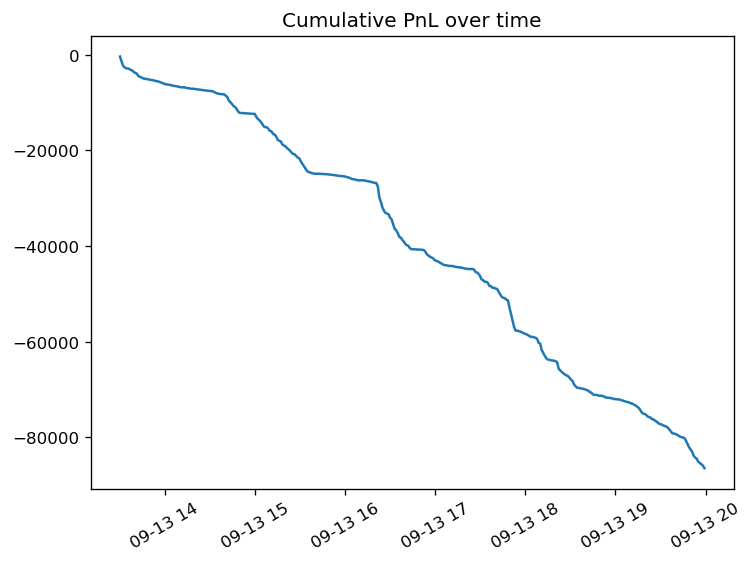

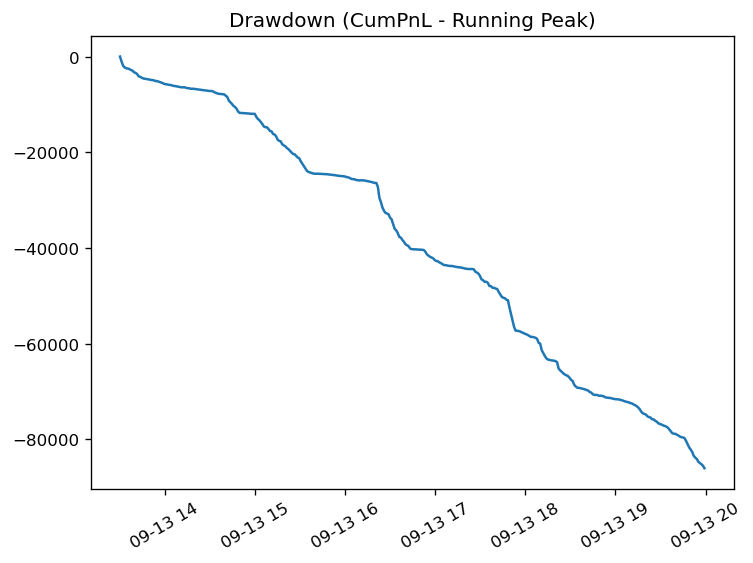

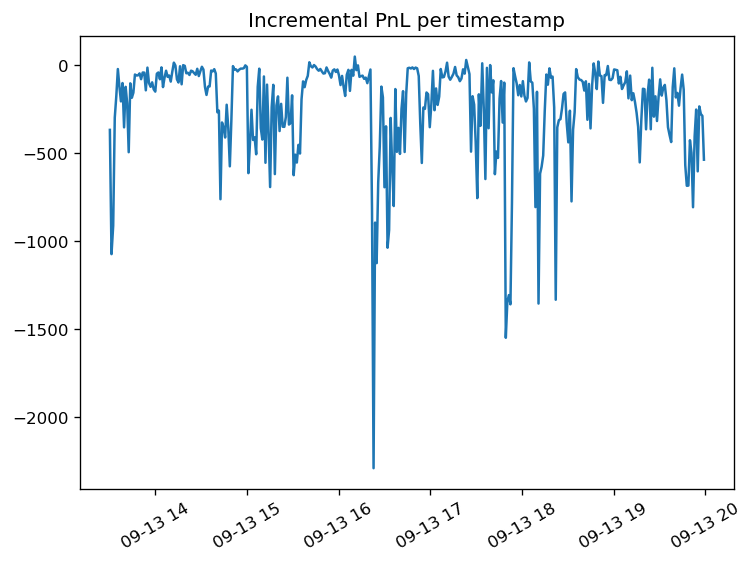

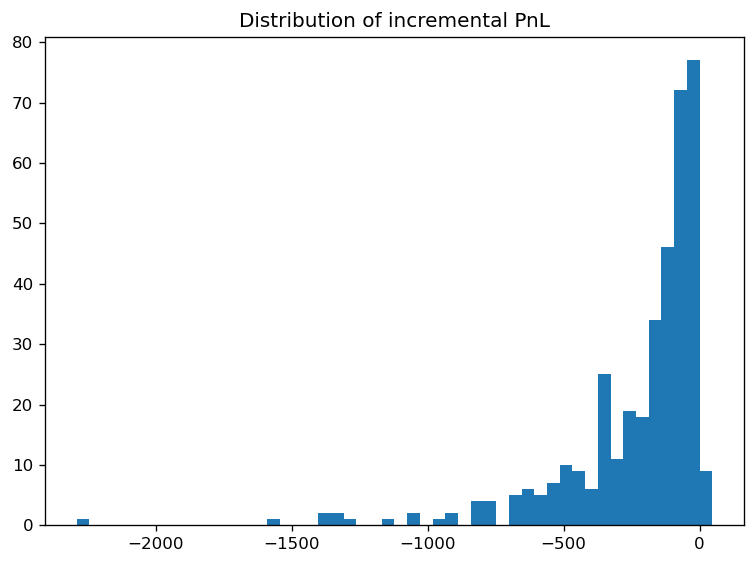

In [8]:
pnl = pnl.sort_values("Time").drop_duplicates(subset=["Time"]).reset_index(drop=True)

# Ensure numeric
pnl["Cumulative PnL"] = pd.to_numeric(pnl["Cumulative PnL"], errors="coerce")
pnl = pnl.dropna(subset=["Cumulative PnL"]).copy()

pnl["PnL"] = pnl["Cumulative PnL"].diff()
pnl.loc[pnl.index[0], "PnL"] = pnl.loc[pnl.index[0], "Cumulative PnL"]

cum = pnl["Cumulative PnL"].astype(float)
pnl["RunningPeak"] = cum.cummax()
pnl["Drawdown"] = cum - pnl["RunningPeak"]

print("Start CumPnL:", float(cum.iloc[0]))
print("End   CumPnL:", float(cum.iloc[-1]))
print("Total PnL:", float(cum.iloc[-1] - cum.iloc[0]))
print("Max Drawdown:", float(pnl["Drawdown"].min()))

plt.figure()
plt.plot(pnl["Time"], pnl["Cumulative PnL"])
plt.title("Cumulative PnL over time")
plt.xticks(rotation=30); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(pnl["Time"], pnl["Drawdown"])
plt.title("Drawdown (CumPnL - Running Peak)")
plt.xticks(rotation=30); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(pnl["Time"], pnl["PnL"])
plt.title("Incremental PnL per timestamp")
plt.xticks(rotation=30); plt.tight_layout(); plt.show()

plt.figure()
plt.hist(pnl["PnL"].dropna(), bins=50)
plt.title("Distribution of incremental PnL")
plt.tight_layout(); plt.show()


## 4) Performance & risk metrics (PnL-space)

We compute PnL-space metrics because we don’t have capital/returns:
- win rate
- avg win / avg loss
- percentiles (tail risk)
- largest win/loss

This explains if the strategy is:
- structurally negative expectancy (most trades lose)
- negatively skewed (fat left tail)


In [10]:
p = pnl["PnL"].dropna()

display(p.describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99]).to_frame("Incremental PnL"))

wins = p[p > 0]
losses = p[p < 0]

metrics = pd.Series({
    "n_obs": len(p),
    "win_rate": float((p > 0).mean()),
    "avg_win": float(wins.mean()) if len(wins) else np.nan,
    "avg_loss": float(losses.mean()) if len(losses) else np.nan,
    "median_pnl": float(p.median()),
    "pnl_std": float(p.std(ddof=1)),
    "largest_gain": float(p.max()),
    "largest_loss": float(p.min()),
})
display(metrics)


,Incremental PnL
count,380.000000
mean,-227.445300
std,280.383459
min,-2290.134375
1%,-1347.532137
5%,-763.766405
10%,-556.339114
25%,-318.301507
50%,-125.320064
75%,-50.505364


n_obs            380.000000
win_rate           0.023684
avg_win           17.878784
avg_loss        -233.396559
median_pnl      -125.320064
pnl_std          280.383459
largest_gain      46.665731
largest_loss   -2290.134375
dtype: float64

## 5) Intraday view (PnL by hour)

Why:
If losses cluster at specific times (e.g., afternoon volatility), that points to:
- regime sensitivity
- poor filters (vol/spread)
- bad execution during certain sessions

What we do:
- group incremental PnL by hour-of-day
- plot total PnL by hour


,count,sum,mean,std
hour,,,,
13,30,-6113.222189,-203.774073,242.235918
14,59,-6231.756148,-105.622986,147.985678
15,58,-13060.131245,-225.174677,206.761686
16,59,-17486.374712,-296.379232,394.440709
17,58,-15429.180345,-266.020351,365.307067
18,58,-13654.897633,-235.429270,279.168679
19,58,-14453.651898,-249.200895,188.397488


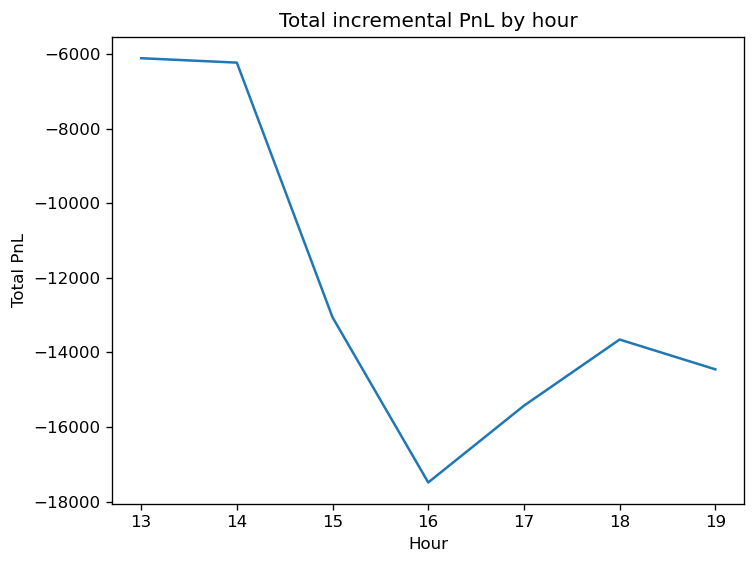

In [12]:
pnl["hour"] = pnl["Time"].dt.hour
by_hour = pnl.groupby("hour")["PnL"].agg(["count","sum","mean","std"])
display(by_hour)

plt.figure()
plt.plot(by_hour.index, by_hour["sum"])
plt.title("Total incremental PnL by hour")
plt.xlabel("Hour"); plt.ylabel("Total PnL")
plt.tight_layout(); plt.show()


## 6) Outliers: worst/best timestamps and drawdown context

Why:
Worst timestamps often correspond to:
- volatility spikes
- spread widening
- runaway trading / adverse selection

What we do:
- show worst 10 and best 10 incremental PnL timestamps
- show context around max drawdown point


In [14]:
worst = pnl.nsmallest(10, "PnL")[["Time","PnL","Cumulative PnL","Drawdown"]]
best  = pnl.nlargest(10, "PnL")[["Time","PnL","Cumulative PnL","Drawdown"]]

print("Worst increments:")
display(worst)
print("Best increments:")
display(best)

def show_context(df, idx, k=8):
    start = max(0, idx-k)
    end = min(len(df)-1, idx+k)
    return df.loc[start:end, ["Time","PnL","Cumulative PnL","Drawdown"]]

idx_dd = int(pnl["Drawdown"].idxmin())
display(show_context(pnl, idx_dd, k=8))


Worst increments:


,Time,PnL,Cumulative PnL,Drawdown
169,2019-09-13 16:22:53.683813,-2290.134375,-29907.855008,-29538.391709
253,2019-09-13 17:49:28.041210,-1549.781635,-52871.049961,-52501.586662
256,2019-09-13 17:52:30.043568,-1359.818606,-56883.796246,-56514.332947
274,2019-09-13 18:10:53.121031,-1355.449206,-61733.211967,-61363.748668
254,2019-09-13 17:50:28.486016,-1345.427600,-54216.477561,-53847.014262
285,2019-09-13 18:22:09.534063,-1333.803986,-65611.362841,-65241.899542
255,2019-09-13 17:51:28.979667,-1307.500079,-55523.977640,-55154.514341
171,2019-09-13 16:24:54.373901,-1125.981398,-31929.723257,-31560.259958
1,2019-09-13 13:31:19.387251,-1074.890139,-1444.353438,-1074.890139
178,2019-09-13 16:32:03.410977,-1038.485938,-35455.382341,-35085.919042


Best increments:


,Time,PnL,Cumulative PnL,Drawdown
157,2019-09-13 16:10:36.270402,46.665731,-26222.471683,-25853.008384
228,2019-09-13 17:23:33.367744,27.391905,-44775.910487,-44406.447188
312,2019-09-13 18:50:02.254113,18.527010,-71263.147781,-70893.684482
128,2019-09-13 15:40:50.698241,14.193277,-24851.571139,-24482.107840
268,2019-09-13 18:04:46.954373,13.507224,-58971.101721,-58601.638422
41,2019-09-13 14:12:08.874430,12.312094,-6788.609594,-6419.146295
216,2019-09-13 17:11:00.551203,12.000594,-44142.079021,-43772.615722
238,2019-09-13 17:34:02.089444,8.505010,-47444.468065,-47075.004766
309,2019-09-13 18:46:59.675196,7.806210,-71095.943088,-70726.479789
243,2019-09-13 17:39:13.503580,-1.462258,-48721.629414,-48352.166115


,Time,PnL,Cumulative PnL,Drawdown
371,2019-09-13 19:51:02.164008,-500.052821,-83011.766918,-82642.303619
372,2019-09-13 19:52:02.684261,-808.611312,-83820.378230,-83450.914931
373,2019-09-13 19:53:05.888515,-405.720575,-84226.098805,-83856.635506
374,2019-09-13 19:54:06.410232,-254.025467,-84480.124272,-84110.660973
375,2019-09-13 19:55:06.667539,-604.874137,-85084.998409,-84715.535110
376,2019-09-13 19:56:08.063802,-236.259451,-85321.257860,-84951.794561
377,2019-09-13 19:57:09.557565,-279.073169,-85600.331029,-85230.867730
378,2019-09-13 19:58:10.543973,-290.062857,-85890.393886,-85520.930587
379,2019-09-13 19:59:11.256736,-538.820284,-86429.214170,-86059.750871


## 7) Join fills ↔ orders

This is the key step that converts “PnL analysis” into “execution diagnosis”.

We join fills to orders using OrderID_norm.

What it answers:
- Do fills map back to orders (join coverage)?
- Are orders mostly MARKET?
- Are fills mostly REMOVED (liquidity-taking)?


In [16]:
of = fills.merge(
    orders,
    on="OrderID_norm",
    how="left",
    suffixes=("_fill", "_order")
)

print("Joined rows (fills):", len(of))

# pick a column that must exist on the ORDER side after merge
order_probe = "OrderID_norm"  # always exists
# if StrategyName exists on both sides, it becomes StrategyName_order
if "StrategyName_order" in of.columns:
    order_probe = "StrategyName_order"
elif "StrategyName" in of.columns:
    order_probe = "StrategyName"
elif "Account_order" in of.columns:
    order_probe = "Account_order"

print("Unmatched fills (no order match):", int(of[order_probe].isna().sum()))

display(of.head(10))
print("Columns after merge (first 30):")
print(of.columns.tolist()[:30])


Joined rows (fills): 9826
Unmatched fills (no order match): 0


,StrategyName_fill,TradeTime,Symbol_fill,Quantity_fill,Price_fill,ExecutionCost_fill,LiquidityAction,LiquidityCode,RawLiquidity,Account_fill,...,AvgFillPrice,ExecutionCost_order,Account_order,Trader_order,Broker,MarketCenter_order,OrderId,Tag,Reason,Closure
0,VWAP8,2019-09-13 13:30:01.012805,AAPL,-1,219.64,0.006120,REMOVED,0,NaN,SIM-1001-101,...,219.64,0.006120,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505854,NaN,NaN,NaN
1,VWAP8,2019-09-13 13:30:01.541646,MSFT,1,137.92,0.001200,REMOVED,0,NaN,SIM-1001-101,...,137.92,0.001200,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505855,NaN,NaN,NaN
2,VWAP8,2019-09-13 13:30:01.630178,MSFT,1,140.84,0.001200,REMOVED,0,NaN,SIM-1001-101,...,140.84,0.001200,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505856,NaN,NaN,NaN
3,VWAP8,2019-09-13 13:30:01.630243,MSFT,1,140.84,0.001200,REMOVED,0,NaN,SIM-1001-101,...,140.84,0.001200,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505857,NaN,NaN,NaN
4,VWAP8,2019-09-13 13:30:01.898861,MSFT,1,140.84,0.001200,REMOVED,0,NaN,SIM-1001-101,...,140.84,0.001200,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505858,NaN,NaN,NaN
5,VWAP8,2019-09-13 13:30:01.898929,MSFT,1,140.84,0.001200,REMOVED,0,NaN,SIM-1001-101,...,140.84,0.001200,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505859,NaN,NaN,NaN
6,VWAP8,2019-09-13 13:30:03.224567,MSFT,-5,128.00,0.020336,REMOVED,0,NaN,SIM-1001-101,...,128.00,0.020336,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505860,NaN,NaN,NaN
7,VWAP8,2019-09-13 13:30:03.225904,MSFT,1,140.84,0.001200,REMOVED,0,NaN,SIM-1001-101,...,140.84,0.001200,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505861,NaN,NaN,NaN
8,VWAP8,2019-09-13 13:30:03.246363,MSFT,1,140.84,0.001200,REMOVED,0,NaN,SIM-1001-101,...,140.84,0.001200,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505862,NaN,NaN,NaN
9,VWAP8,2019-09-13 13:30:03.362636,MSFT,1,140.84,0.001200,REMOVED,0,NaN,SIM-1001-101,...,140.84,0.001200,SIM-1001-101,dlariviere,FILL_SIMULATOR,NASDAQ,369229748505863,NaN,NaN,NaN


Columns after merge (first 30):
['StrategyName_fill', 'TradeTime', 'Symbol_fill', 'Quantity_fill', 'Price_fill', 'ExecutionCost_fill', 'LiquidityAction', 'LiquidityCode', 'RawLiquidity', 'Account_fill', 'Trader_fill', 'MarketCenter_fill', 'OrderID', 'ExecID', 'TransactionType', 'OrderID_norm', 'StrategyName_order', 'EntryTime', 'LastModTime', 'State', 'LastUpdateType', 'Symbol_order', 'Side', 'Type', 'TIF', 'Price_order', 'Quantity_order', 'DisplayQuantity', 'FilledQty', 'Remains']


In [17]:
match_rate = 1 - of[order_probe].isna().mean()
print(f"Fill→Order match rate: {match_rate:.2%}")

Fill→Order match rate: 100.00%


## 8) Orders behavior (intent)

We inspect:
- order Type (MARKET vs LIMIT)
- Side (BUY vs SELL)
- Quantity distribution
- State (FILLED etc.)

This tells us if strategy behavior itself is aggressive / overtrading.


In [19]:
print("Total orders:", len(orders))

if "Type" in orders.columns:
    display(orders["Type"].value_counts(dropna=False).to_frame("count"))

if "Side" in orders.columns:
    display(orders["Side"].value_counts(dropna=False).to_frame("count"))

if "Quantity" in orders.columns:
    display(orders["Quantity"].describe().to_frame("order_qty"))

if "State" in orders.columns:
    display(orders["State"].value_counts(dropna=False).to_frame("count"))


Total orders: 9826


,count
Type,
MARKET,9826


,count
Side,
BUY,5410
SELL,4416


,order_qty
count,9826.000000
mean,0.000000
std,2.223996
min,-5.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,5.000000


,count
State,
FILLED,9826


## 9) Fills behavior (reality)

We inspect:
- LiquidityAction (REMOVED = crossing spread)
- ExecutionCost (fees/rebates proxy)
- Symbol concentration

This tells us if execution mechanics explain the persistent losses.


In [21]:
print("Total fills:", len(fills))

if "LiquidityAction" in fills.columns:
    display(fills["LiquidityAction"].value_counts(dropna=False).to_frame("count"))

if "ExecutionCost" in fills.columns:
    display(fills["ExecutionCost"].describe().to_frame("exec_cost"))

if "Symbol" in fills.columns:
    display(fills["Symbol"].value_counts().head(20).to_frame("top_symbols"))


Total fills: 9826


,count
LiquidityAction,
REMOVED,9826


,exec_cost
count,9826.000000
mean,0.005090
std,0.005760
min,0.001200
25%,0.001200
50%,0.005008
75%,0.006084
max,0.030571


,top_symbols
Symbol,
MSFT,5186
AAPL,4584
DIA,56


## 10) Minute-level alignment: attribute execution to PnL

PnL is sampled at timestamps (often ~1 minute). Fills happen at trade times.
To connect them, we bucket both to minute:

- PnL per minute = sum of incremental PnL within the minute
- Fills per minute = sum qty, sum execution cost, count REMOVED

This gives a combined panel:
minute_panel = [PnL metrics + execution metrics] per minute

Then we can ask:
- Do minutes with higher execution costs have worse PnL?
- Do minutes with many REMOVED fills have worse PnL?
- Which minutes are the biggest loss contributors?


In [23]:
pnl_min = pnl.copy()
pnl_min["minute"] = pnl_min["Time"].dt.floor("min")

fills_min = fills.copy()
fills_min["minute"] = fills_min["TradeTime"].dt.floor("min")

# Aggregate fills per minute
agg = {}
if "Quantity" in fills_min.columns: agg["Quantity"] = "sum"
if "ExecutionCost" in fills_min.columns: agg["ExecutionCost"] = "sum"

if "LiquidityAction" in fills_min.columns:
    fills_min["is_removed"] = (fills_min["LiquidityAction"].astype(str).str.upper() == "REMOVED").astype(int)
    agg["is_removed"] = "sum"

fills_by_min = fills_min.groupby("minute", as_index=False).agg(agg).rename(columns={
    "Quantity": "fill_qty_sum",
    "ExecutionCost": "exec_cost_sum",
    "is_removed": "removed_count"
})

# Aggregate pnl per minute
pnl_by_min = pnl_min.groupby("minute", as_index=False).agg({
    "PnL": "sum",
    "Cumulative PnL": "last",
    "Drawdown": "last"
}).rename(columns={"PnL": "pnl_min_sum"})

minute_panel = pnl_by_min.merge(fills_by_min, on="minute", how="left")

for c in ["fill_qty_sum","exec_cost_sum","removed_count"]:
    if c in minute_panel.columns:
        minute_panel[c] = minute_panel[c].fillna(0)

display(minute_panel.head(10))


,minute,pnl_min_sum,Cumulative PnL,Drawdown,fill_qty_sum,exec_cost_sum,removed_count
0,2019-09-13 13:30:00,-369.463299,-369.463299,0.000000,-3,0.439464,86
1,2019-09-13 13:31:00,-1074.890139,-1444.353438,-1074.890139,3,0.158145,33
2,2019-09-13 13:32:00,-913.508782,-2357.862220,-1988.398921,3,0.142311,29
3,2019-09-13 13:33:00,-300.034210,-2657.896430,-2288.433131,-3,0.255284,51
4,2019-09-13 13:34:00,-177.328676,-2835.225106,-2465.761807,-2,0.165256,30
5,2019-09-13 13:35:00,-24.014588,-2859.239694,-2489.776395,4,0.307353,62
6,2019-09-13 13:36:00,-122.427146,-2981.666840,-2612.203541,-2,0.168885,30
7,2019-09-13 13:37:00,-207.684078,-3189.350918,-2819.887619,1,0.179698,31
8,2019-09-13 13:38:00,-103.520132,-3292.871050,-2923.407751,-3,0.231248,43
9,2019-09-13 13:39:00,-355.121648,-3647.992698,-3278.529399,1,0.178536,35


## 11) Execution vs PnL plots

These plots are “debugging lenses”:
- If execution costs (or liquidity removal) rises when PnL becomes very negative,
  execution mechanics may be the driver.
- If PnL is negative even with low execution costs,
  the signal/strategy logic itself is likely broken.

We plot:
- PnL per minute over time
- execution cost per minute over time
- scatter: execution cost vs pnl
- scatter: removed_count vs pnl (if available)


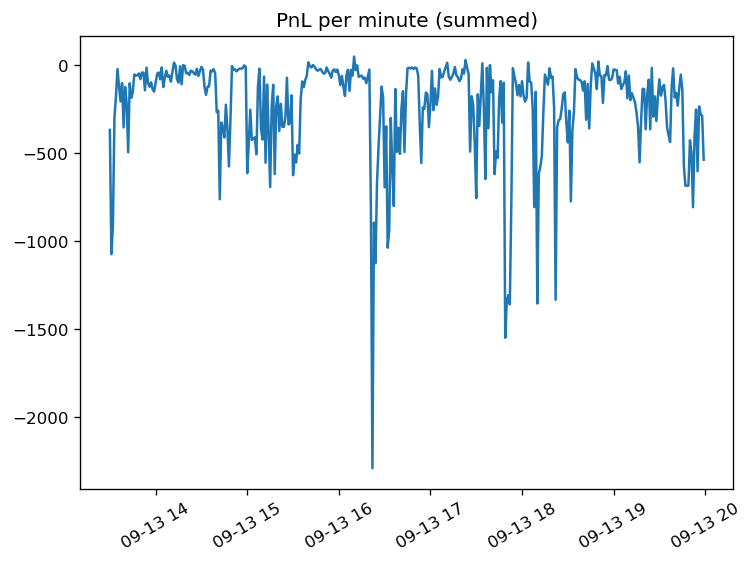

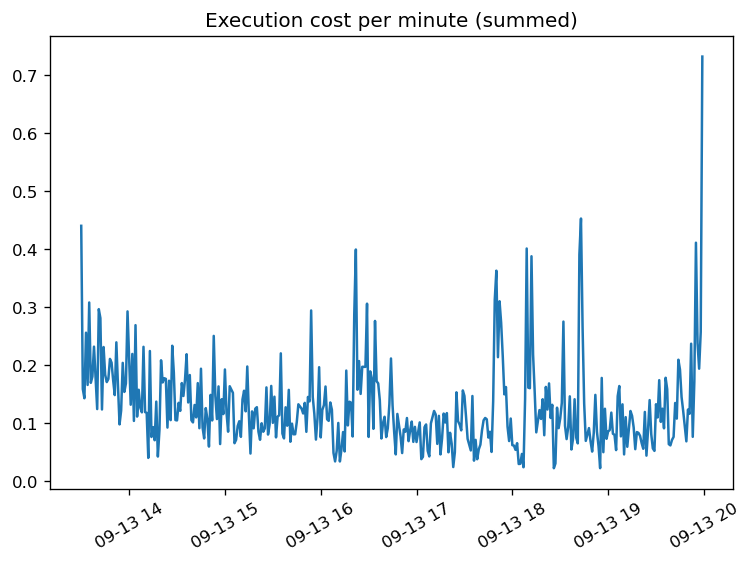

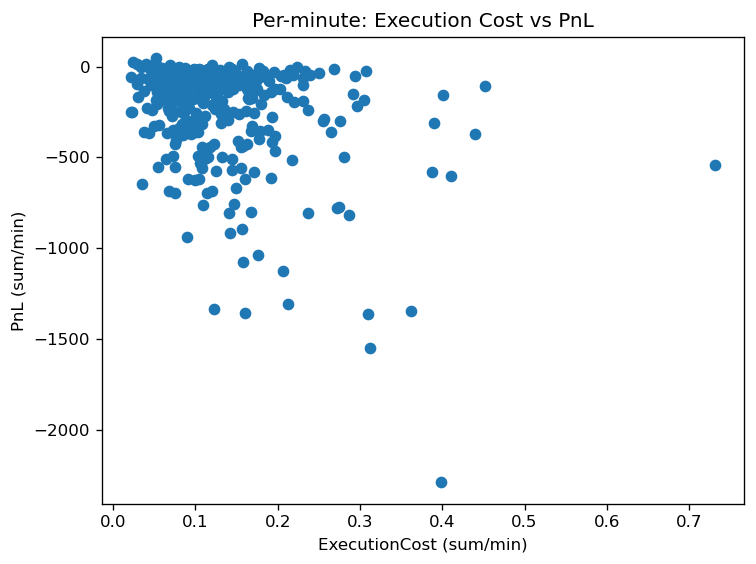

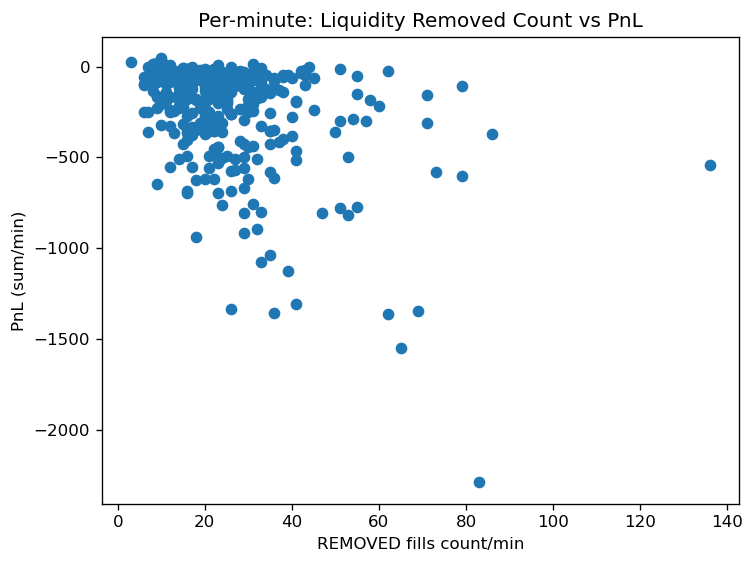

In [25]:
plt.figure()
plt.plot(minute_panel["minute"], minute_panel["pnl_min_sum"])
plt.title("PnL per minute (summed)")
plt.xticks(rotation=30); plt.tight_layout(); plt.show()

if "exec_cost_sum" in minute_panel.columns:
    plt.figure()
    plt.plot(minute_panel["minute"], minute_panel["exec_cost_sum"])
    plt.title("Execution cost per minute (summed)")
    plt.xticks(rotation=30); plt.tight_layout(); plt.show()

    plt.figure()
    plt.scatter(minute_panel["exec_cost_sum"], minute_panel["pnl_min_sum"])
    plt.title("Per-minute: Execution Cost vs PnL")
    plt.xlabel("ExecutionCost (sum/min)")
    plt.ylabel("PnL (sum/min)")
    plt.tight_layout(); plt.show()

if "removed_count" in minute_panel.columns:
    plt.figure()
    plt.scatter(minute_panel["removed_count"], minute_panel["pnl_min_sum"])
    plt.title("Per-minute: Liquidity Removed Count vs PnL")
    plt.xlabel("REMOVED fills count/min")
    plt.ylabel("PnL (sum/min)")
    plt.tight_layout(); plt.show()


## 12) Worst minutes + drilldown

We find the worst minutes by PnL, then inspect:
- nearby minutes (context)
- the fills that occurred inside the worst minute

This is usually where the story becomes obvious:
e.g., “we fired many market buys into a falling tape and removed liquidity each time”.


In [27]:
worst_minutes = minute_panel.nsmallest(15, "pnl_min_sum")
display(worst_minutes)

def show_minute_context(ts, k=5):
    ts = pd.to_datetime(ts)
    lo = ts - pd.Timedelta(minutes=k)
    hi = ts + pd.Timedelta(minutes=k)
    return minute_panel[(minute_panel["minute"]>=lo) & (minute_panel["minute"]<=hi)]

def show_fills_in_minute(ts, max_rows=200):
    ts = pd.to_datetime(ts)
    return fills_min[fills_min["minute"] == ts].sort_values("TradeTime").head(max_rows)

if len(worst_minutes) > 0:
    worst_ts = worst_minutes["minute"].iloc[0]
    print("Worst minute:", worst_ts)
    display(show_minute_context(worst_ts, k=8))
    display(show_fills_in_minute(worst_ts, max_rows=100))


,minute,pnl_min_sum,Cumulative PnL,Drawdown,fill_qty_sum,exec_cost_sum,removed_count
169,2019-09-13 16:22:00,-2290.134375,-29907.855008,-29538.391709,2,0.398639,83
253,2019-09-13 17:49:00,-1549.781635,-52871.049961,-52501.586662,1,0.312134,65
256,2019-09-13 17:52:00,-1359.818606,-56883.796246,-56514.332947,-2,0.309489,62
274,2019-09-13 18:10:00,-1355.449206,-61733.211967,-61363.748668,6,0.160567,36
254,2019-09-13 17:50:00,-1345.427600,-54216.477561,-53847.014262,5,0.362159,69
285,2019-09-13 18:22:00,-1333.803986,-65611.362841,-65241.899542,2,0.122894,26
255,2019-09-13 17:51:00,-1307.500079,-55523.977640,-55154.514341,-1,0.213078,41
171,2019-09-13 16:24:00,-1125.981398,-31929.723257,-31560.259958,-3,0.206392,39
1,2019-09-13 13:31:00,-1074.890139,-1444.353438,-1074.890139,3,0.158145,33
178,2019-09-13 16:32:00,-1038.485938,-35455.382341,-35085.919042,4,0.176213,35


Worst minute: 2019-09-13 16:22:00


,minute,pnl_min_sum,Cumulative PnL,Drawdown,fill_qty_sum,exec_cost_sum,removed_count
161,2019-09-13 16:14:00,-64.241030,-26388.781701,-26019.318402,1,0.084090,17
162,2019-09-13 16:15:00,-61.523729,-26450.305430,-26080.842131,-4,0.050668,10
163,2019-09-13 16:16:00,-79.519119,-26529.824549,-26160.361250,2,0.190021,36
164,2019-09-13 16:17:00,-72.817025,-26602.641574,-26233.178275,3,0.095487,19
165,2019-09-13 16:18:00,-104.202343,-26706.843917,-26337.380618,-4,0.136345,24
166,2019-09-13 16:19:00,-65.388544,-26772.232461,-26402.769162,-4,0.134622,26
167,2019-09-13 16:20:00,-26.785881,-26799.018342,-26429.555043,3,0.076430,15
168,2019-09-13 16:21:00,-818.702291,-27617.720633,-27248.257334,3,0.286665,53
169,2019-09-13 16:22:00,-2290.134375,-29907.855008,-29538.391709,2,0.398639,83
170,2019-09-13 16:23:00,-895.886851,-30803.741859,-30434.278560,1,0.157010,32


,StrategyName,TradeTime,Symbol,Quantity,Price,ExecutionCost,LiquidityAction,LiquidityCode,RawLiquidity,Account,Trader,MarketCenter,OrderID,ExecID,TransactionType,OrderID_norm,minute,is_removed
4562,VWAP8,2019-09-13 16:22:00.070152,AAPL,1,217.73,0.00120,REMOVED,0,NaN,SIM-1001-101,dlariviere,NASDAQ,369229748510416,NaN,FILL,369229748510416,2019-09-13 16:22:00,1
4563,VWAP8,2019-09-13 16:22:01.062011,AAPL,1,217.69,0.00120,REMOVED,0,NaN,SIM-1001-101,dlariviere,NASDAQ,369229748510417,NaN,FILL,369229748510417,2019-09-13 16:22:00,1
4564,VWAP8,2019-09-13 16:22:02.247691,AAPL,-5,170.00,0.02504,REMOVED,0,NaN,SIM-1001-101,dlariviere,NASDAQ,369229748510418,NaN,FILL,369229748510418,2019-09-13 16:22:00,1
4565,VWAP8,2019-09-13 16:22:02.247709,AAPL,1,217.69,0.00120,REMOVED,0,NaN,SIM-1001-101,dlariviere,NASDAQ,369229748510419,NaN,FILL,369229748510419,2019-09-13 16:22:00,1
4566,VWAP8,2019-09-13 16:22:02.322895,MSFT,1,137.53,0.00120,REMOVED,0,NaN,SIM-1001-101,dlariviere,NASDAQ,369229748510420,NaN,FILL,369229748510420,2019-09-13 16:22:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4640,VWAP8,2019-09-13 16:22:54.548964,AAPL,-5,170.00,0.02504,REMOVED,0,NaN,SIM-1001-101,dlariviere,NASDAQ,369229748510494,NaN,FILL,369229748510494,2019-09-13 16:22:00,1
4641,VWAP8,2019-09-13 16:22:55.320504,AAPL,1,217.42,0.00120,REMOVED,0,NaN,SIM-1001-101,dlariviere,NASDAQ,369229748510495,NaN,FILL,369229748510495,2019-09-13 16:22:00,1
4642,VWAP8,2019-09-13 16:22:55.672262,AAPL,1,217.42,0.00120,REMOVED,0,NaN,SIM-1001-101,dlariviere,NASDAQ,369229748510496,NaN,FILL,369229748510496,2019-09-13 16:22:00,1
4643,VWAP8,2019-09-13 16:22:57.346707,AAPL,1,217.42,0.00120,REMOVED,0,NaN,SIM-1001-101,dlariviere,NASDAQ,369229748510497,NaN,FILL,369229748510497,2019-09-13 16:22:00,1


## 13) Conclusions checklist

After running this notebook, you can confidently answer:

1) Strategy quality:
- Is PnL a steady bleed? Is drawdown continuous?

2) Trade-level expectancy:
- win rate, avg win/loss, tails → is this mathematically negative expectancy?

3) Time-of-day:
- which hours are worst?

4) Execution drivers:
- do high exec-cost / high REMOVED minutes correspond to worst PnL?

5) Debug next steps:
- If execution is the issue: add spread/vol filters, reduce market orders, throttle trades
- If signal is the issue: rethink VWAP logic, trend alignment, regime filters, kill-switch


## Executive Summary

The VWAP8 strategy exhibits persistent negative PnL over the trading session, with a
maximum drawdown of ~87k and no meaningful recovery. Incremental PnL distribution
shows a low win rate (~20%), capped upside, and large downside tail events.

Losses are not isolated but occur steadily throughout the session, with pronounced
clustering during mid-to-late trading hours. Intraday analysis reveals that the worst
PnL minutes coincide with elevated trading activity and higher execution costs.

Execution analysis shows that the strategy primarily uses MARKET orders and frequently
removes liquidity. Per-minute execution cost and liquidity removal counts are positively
associated with negative PnL, indicating adverse selection and spread-crossing losses.

Conclusion: The observed losses are driven by a combination of weak signal quality and
aggressive execution. Without changes to trade filtering, execution style, or regime
controls, the strategy is not viable in its current form.
